라이브러리

In [72]:
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230714_tank1_nonlinear_10min'

In [73]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [74]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [75]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [76]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

#시계열 10분 단위로 변경
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.resample('10T', on='mea_dt').mean()
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.resample('10T', on='mea_dt').mean()

#null 삭제
japonica_training_sensor_val_tb.dropna(inplace=True)
japonica_validation_sensor_val_tb.dropna(inplace=True)

#인덱스 복구
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.reset_index()
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.reset_index()

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 144이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 144].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 144].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [77]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [78]:
japonica_training_features_X = japonica_training_data[['do_mg', 'feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [79]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)

In [123]:
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6912 nVar: 2
nCar: 6912 nVar: 1
nCar: 6912 nVar: 2
nCar: 6912 nVar: 1


In [80]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-18]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[18:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-18]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[18:]

In [81]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6894 nVar: 2
nCar: 6894 nVar: 1
nCar: 6894 nVar: 2
nCar: 6894 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [82]:
# Create model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=2))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])
model.save(model_name+'.h5')

Epoch 1/10000000


/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


69/69 - 1s - loss: 22.2836 - val_loss: 0.7689
Epoch 2/10000000
69/69 - 0s - loss: 0.5751 - val_loss: 0.5574
Epoch 3/10000000
69/69 - 0s - loss: 0.5557 - val_loss: 0.5541
Epoch 4/10000000
69/69 - 0s - loss: 0.5545 - val_loss: 0.5532
Epoch 5/10000000
69/69 - 1s - loss: 0.5541 - val_loss: 0.5534
Epoch 6/10000000
69/69 - 0s - loss: 0.5522 - val_loss: 0.5506
Epoch 7/10000000
69/69 - 0s - loss: 0.5527 - val_loss: 0.5515
Epoch 8/10000000
69/69 - 0s - loss: 0.5504 - val_loss: 0.5489
Epoch 9/10000000
69/69 - 0s - loss: 0.5490 - val_loss: 0.5475
Epoch 10/10000000
69/69 - 0s - loss: 0.5490 - val_loss: 0.5502
Epoch 11/10000000
69/69 - 0s - loss: 0.5465 - val_loss: 0.5470
Epoch 12/10000000
69/69 - 0s - loss: 0.5465 - val_loss: 0.5508
Epoch 13/10000000
69/69 - 0s - loss: 0.5450 - val_loss: 0.5414
Epoch 14/10000000
69/69 - 0s - loss: 0.5423 - val_loss: 0.5405
Epoch 15/10000000
69/69 - 0s - loss: 0.5425 - val_loss: 0.5387
Epoch 16/10000000
69/69 - 0s - loss: 0.5396 - val_loss: 0.5373
Epoch 17/10000000

Epoch 131/10000000
69/69 - 1s - loss: 0.5262 - val_loss: 0.5189
Epoch 132/10000000
69/69 - 1s - loss: 0.5222 - val_loss: 0.5191
Epoch 133/10000000
69/69 - 1s - loss: 0.5225 - val_loss: 0.5308
Epoch 134/10000000
69/69 - 1s - loss: 0.5247 - val_loss: 0.5175
Epoch 135/10000000
69/69 - 1s - loss: 0.5215 - val_loss: 0.5235
Epoch 136/10000000
69/69 - 1s - loss: 0.5327 - val_loss: 0.5233
Epoch 137/10000000
69/69 - 1s - loss: 0.5200 - val_loss: 0.5175
Epoch 138/10000000
69/69 - 1s - loss: 0.5201 - val_loss: 0.5184
Epoch 139/10000000
69/69 - 1s - loss: 0.5231 - val_loss: 0.5167
Epoch 140/10000000
69/69 - 1s - loss: 0.5238 - val_loss: 0.5198
Epoch 141/10000000
69/69 - 1s - loss: 0.5205 - val_loss: 0.5170
Epoch 142/10000000
69/69 - 1s - loss: 0.5220 - val_loss: 0.5197
Epoch 143/10000000
69/69 - 1s - loss: 0.5263 - val_loss: 0.5227
Epoch 144/10000000
69/69 - 1s - loss: 0.5199 - val_loss: 0.5184
Epoch 145/10000000
69/69 - 1s - loss: 0.5228 - val_loss: 0.5348
Epoch 146/10000000
69/69 - 1s - loss: 0.

69/69 - 1s - loss: 0.5180 - val_loss: 0.5230
Epoch 260/10000000
69/69 - 1s - loss: 0.5218 - val_loss: 0.5250
Epoch 261/10000000
69/69 - 1s - loss: 0.5198 - val_loss: 0.5172
Epoch 262/10000000
69/69 - 1s - loss: 0.5192 - val_loss: 0.5262
Epoch 263/10000000
69/69 - 1s - loss: 0.5184 - val_loss: 0.5176
Epoch 264/10000000
69/69 - 1s - loss: 0.5210 - val_loss: 0.5202
Epoch 265/10000000
69/69 - 1s - loss: 0.5176 - val_loss: 0.5177
Epoch 266/10000000
69/69 - 1s - loss: 0.5201 - val_loss: 0.5180
Epoch 267/10000000
69/69 - 1s - loss: 0.5178 - val_loss: 0.5182
Epoch 268/10000000
69/69 - 1s - loss: 0.5260 - val_loss: 0.5245
Epoch 269/10000000
69/69 - 1s - loss: 0.5237 - val_loss: 0.5187
Epoch 270/10000000
69/69 - 1s - loss: 0.5281 - val_loss: 0.5255
Epoch 271/10000000
69/69 - 1s - loss: 0.5245 - val_loss: 0.5202
Epoch 272/10000000
69/69 - 1s - loss: 0.5228 - val_loss: 0.5172
Epoch 273/10000000
69/69 - 1s - loss: 0.5197 - val_loss: 0.5166
Epoch 274/10000000
69/69 - 1s - loss: 0.5199 - val_loss: 0.

Epoch 388/10000000
69/69 - 1s - loss: 0.5181 - val_loss: 0.5171
Epoch 389/10000000
69/69 - 1s - loss: 0.5169 - val_loss: 0.5231
Epoch 390/10000000
69/69 - 1s - loss: 0.5186 - val_loss: 0.5152
Epoch 391/10000000
69/69 - 1s - loss: 0.5221 - val_loss: 0.5265
Epoch 392/10000000
69/69 - 1s - loss: 0.5221 - val_loss: 0.5192
Epoch 393/10000000
69/69 - 1s - loss: 0.5190 - val_loss: 0.5178
Epoch 394/10000000
69/69 - 1s - loss: 0.5185 - val_loss: 0.5206
Epoch 395/10000000
69/69 - 1s - loss: 0.5245 - val_loss: 0.5334
Epoch 396/10000000
69/69 - 1s - loss: 0.5292 - val_loss: 0.5191
Epoch 397/10000000
69/69 - 1s - loss: 0.5195 - val_loss: 0.5200
Epoch 398/10000000
69/69 - 1s - loss: 0.5192 - val_loss: 0.5254
Epoch 399/10000000
69/69 - 1s - loss: 0.5186 - val_loss: 0.5177
Epoch 400/10000000
69/69 - 1s - loss: 0.5198 - val_loss: 0.5208
Epoch 401/10000000
69/69 - 1s - loss: 0.5186 - val_loss: 0.5153
Epoch 402/10000000
69/69 - 1s - loss: 0.5169 - val_loss: 0.5185
Epoch 403/10000000
69/69 - 1s - loss: 0.

69/69 - 0s - loss: 0.5159 - val_loss: 0.5253
Epoch 517/10000000
69/69 - 1s - loss: 0.5249 - val_loss: 0.5195
Epoch 518/10000000
69/69 - 1s - loss: 0.5178 - val_loss: 0.5169
Epoch 519/10000000
69/69 - 1s - loss: 0.5181 - val_loss: 0.5401
Epoch 520/10000000
69/69 - 1s - loss: 0.5185 - val_loss: 0.5270
Epoch 521/10000000
69/69 - 1s - loss: 0.5213 - val_loss: 0.5158
Epoch 522/10000000
69/69 - 1s - loss: 0.5215 - val_loss: 0.5246
Epoch 523/10000000
69/69 - 1s - loss: 0.5187 - val_loss: 0.5156
Epoch 524/10000000
69/69 - 1s - loss: 0.5223 - val_loss: 0.5216
Epoch 525/10000000
69/69 - 1s - loss: 0.5202 - val_loss: 0.5165
Epoch 526/10000000
69/69 - 1s - loss: 0.5217 - val_loss: 0.5153
Epoch 527/10000000
69/69 - 1s - loss: 0.5188 - val_loss: 0.5340
Epoch 528/10000000
69/69 - 1s - loss: 0.5226 - val_loss: 0.5208
Epoch 529/10000000
69/69 - 1s - loss: 0.5191 - val_loss: 0.5175
Epoch 530/10000000
69/69 - 1s - loss: 0.5173 - val_loss: 0.5146
Epoch 531/10000000
69/69 - 1s - loss: 0.5179 - val_loss: 0.

Epoch 645/10000000
69/69 - 1s - loss: 0.5187 - val_loss: 0.5154
Epoch 646/10000000
69/69 - 1s - loss: 0.5202 - val_loss: 0.5224
Epoch 647/10000000
69/69 - 1s - loss: 0.5216 - val_loss: 0.5199
Epoch 648/10000000
69/69 - 1s - loss: 0.5219 - val_loss: 0.5205
Epoch 649/10000000
69/69 - 1s - loss: 0.5244 - val_loss: 0.5166
Epoch 650/10000000
69/69 - 1s - loss: 0.5175 - val_loss: 0.5234
Epoch 651/10000000
69/69 - 1s - loss: 0.5188 - val_loss: 0.5164
Epoch 652/10000000
69/69 - 1s - loss: 0.5209 - val_loss: 0.5248
Epoch 653/10000000
69/69 - 1s - loss: 0.5183 - val_loss: 0.5157
Epoch 654/10000000
69/69 - 1s - loss: 0.5204 - val_loss: 0.5181
Epoch 655/10000000
69/69 - 1s - loss: 0.5209 - val_loss: 0.5236
Epoch 656/10000000
69/69 - 1s - loss: 0.5276 - val_loss: 0.5146
Epoch 657/10000000
69/69 - 1s - loss: 0.5173 - val_loss: 0.5150
Epoch 658/10000000
69/69 - 1s - loss: 0.5168 - val_loss: 0.5322
Epoch 659/10000000
69/69 - 1s - loss: 0.5204 - val_loss: 0.5157
Epoch 660/10000000
69/69 - 1s - loss: 0.

69/69 - 1s - loss: 0.5174 - val_loss: 0.5147
Epoch 774/10000000
69/69 - 1s - loss: 0.5188 - val_loss: 0.5141
Epoch 775/10000000
69/69 - 1s - loss: 0.5184 - val_loss: 0.5156
Epoch 776/10000000
69/69 - 1s - loss: 0.5155 - val_loss: 0.5257
Epoch 777/10000000
69/69 - 1s - loss: 0.5159 - val_loss: 0.5138
Epoch 778/10000000
69/69 - 1s - loss: 0.5181 - val_loss: 0.5224
Epoch 779/10000000
69/69 - 1s - loss: 0.5169 - val_loss: 0.5143
Epoch 780/10000000
69/69 - 1s - loss: 0.5183 - val_loss: 0.5234
Epoch 781/10000000
69/69 - 1s - loss: 0.5172 - val_loss: 0.5227
Epoch 782/10000000
69/69 - 1s - loss: 0.5201 - val_loss: 0.5156
Epoch 783/10000000
69/69 - 1s - loss: 0.5174 - val_loss: 0.5139
Epoch 784/10000000
69/69 - 1s - loss: 0.5166 - val_loss: 0.5194
Epoch 785/10000000
69/69 - 1s - loss: 0.5168 - val_loss: 0.5158
Epoch 786/10000000
69/69 - 1s - loss: 0.5163 - val_loss: 0.5136
Epoch 787/10000000
69/69 - 1s - loss: 0.5175 - val_loss: 0.5295
Epoch 788/10000000
69/69 - 1s - loss: 0.5197 - val_loss: 0.

Epoch 902/10000000
69/69 - 1s - loss: 0.5159 - val_loss: 0.5126
Epoch 903/10000000
69/69 - 1s - loss: 0.5158 - val_loss: 0.5151
Epoch 904/10000000
69/69 - 1s - loss: 0.5143 - val_loss: 0.5209
Epoch 905/10000000
69/69 - 1s - loss: 0.5146 - val_loss: 0.5140
Epoch 906/10000000
69/69 - 1s - loss: 0.5158 - val_loss: 0.5122
Epoch 907/10000000
69/69 - 1s - loss: 0.5173 - val_loss: 0.5123
Epoch 908/10000000
69/69 - 1s - loss: 0.5162 - val_loss: 0.5175
Epoch 909/10000000
69/69 - 0s - loss: 0.5163 - val_loss: 0.5162
Epoch 910/10000000
69/69 - 0s - loss: 0.5161 - val_loss: 0.5128
Epoch 911/10000000
69/69 - 0s - loss: 0.5185 - val_loss: 0.5190
Epoch 912/10000000
69/69 - 0s - loss: 0.5151 - val_loss: 0.5178
Epoch 913/10000000
69/69 - 0s - loss: 0.5144 - val_loss: 0.5132
Epoch 914/10000000
69/69 - 0s - loss: 0.5148 - val_loss: 0.5164
Epoch 915/10000000
69/69 - 0s - loss: 0.5166 - val_loss: 0.5196
Epoch 916/10000000
69/69 - 0s - loss: 0.5153 - val_loss: 0.5130
Epoch 917/10000000
69/69 - 0s - loss: 0.

Epoch 1030/10000000
69/69 - 0s - loss: 0.5147 - val_loss: 0.5129
Epoch 1031/10000000
69/69 - 1s - loss: 0.5151 - val_loss: 0.5117
Epoch 1032/10000000
69/69 - 1s - loss: 0.5155 - val_loss: 0.5124
Epoch 1033/10000000
69/69 - 1s - loss: 0.5144 - val_loss: 0.5114
Epoch 1034/10000000
69/69 - 1s - loss: 0.5155 - val_loss: 0.5222
Epoch 1035/10000000
69/69 - 1s - loss: 0.5157 - val_loss: 0.5153
Epoch 1036/10000000
69/69 - 1s - loss: 0.5128 - val_loss: 0.5114
Epoch 1037/10000000
69/69 - 1s - loss: 0.5146 - val_loss: 0.5131
Epoch 1038/10000000
69/69 - 1s - loss: 0.5167 - val_loss: 0.5113
Epoch 1039/10000000
69/69 - 1s - loss: 0.5156 - val_loss: 0.5395
Epoch 1040/10000000
69/69 - 1s - loss: 0.5149 - val_loss: 0.5137
Epoch 1041/10000000
69/69 - 1s - loss: 0.5151 - val_loss: 0.5140
Epoch 1042/10000000
69/69 - 1s - loss: 0.5147 - val_loss: 0.5107
Epoch 1043/10000000
69/69 - 1s - loss: 0.5137 - val_loss: 0.5209
Epoch 1044/10000000
69/69 - 1s - loss: 0.5187 - val_loss: 0.5182
Epoch 1045/10000000
69/69

69/69 - 1s - loss: 0.5139 - val_loss: 0.5096
Epoch 1157/10000000
69/69 - 0s - loss: 0.5155 - val_loss: 0.5117
Epoch 1158/10000000
69/69 - 1s - loss: 0.5148 - val_loss: 0.5388
Epoch 1159/10000000
69/69 - 0s - loss: 0.5170 - val_loss: 0.5157
Epoch 1160/10000000
69/69 - 0s - loss: 0.5130 - val_loss: 0.5120
Epoch 1161/10000000
69/69 - 1s - loss: 0.5155 - val_loss: 0.5124
Epoch 1162/10000000
69/69 - 1s - loss: 0.5132 - val_loss: 0.5112
Epoch 1163/10000000
69/69 - 1s - loss: 0.5114 - val_loss: 0.5106
Epoch 1164/10000000
69/69 - 1s - loss: 0.5142 - val_loss: 0.5158
Epoch 1165/10000000
69/69 - 1s - loss: 0.5133 - val_loss: 0.5100
Epoch 1166/10000000
69/69 - 1s - loss: 0.5126 - val_loss: 0.5108
Epoch 1167/10000000
69/69 - 1s - loss: 0.5151 - val_loss: 0.5121
Epoch 1168/10000000
69/69 - 1s - loss: 0.5141 - val_loss: 0.5121
Epoch 1169/10000000
69/69 - 1s - loss: 0.5145 - val_loss: 0.5211
Epoch 1170/10000000
69/69 - 1s - loss: 0.5148 - val_loss: 0.5096
Epoch 1171/10000000
69/69 - 1s - loss: 0.5127

Epoch 1283/10000000
69/69 - 0s - loss: 0.5114 - val_loss: 0.5095
Epoch 1284/10000000
69/69 - 0s - loss: 0.5118 - val_loss: 0.5116
Epoch 1285/10000000
69/69 - 0s - loss: 0.5129 - val_loss: 0.5116
Epoch 1286/10000000
69/69 - 0s - loss: 0.5123 - val_loss: 0.5100
Epoch 1287/10000000
69/69 - 0s - loss: 0.5127 - val_loss: 0.5093
Epoch 1288/10000000
69/69 - 0s - loss: 0.5136 - val_loss: 0.5125
Epoch 1289/10000000
69/69 - 0s - loss: 0.5188 - val_loss: 0.5119
Epoch 1290/10000000
69/69 - 0s - loss: 0.5145 - val_loss: 0.5108
Epoch 1291/10000000
69/69 - 0s - loss: 0.5127 - val_loss: 0.5096
Epoch 1292/10000000
69/69 - 0s - loss: 0.5110 - val_loss: 0.5113
Epoch 1293/10000000
69/69 - 0s - loss: 0.5130 - val_loss: 0.5158
Epoch 1294/10000000
69/69 - 0s - loss: 0.5139 - val_loss: 0.5085
Epoch 1295/10000000
69/69 - 0s - loss: 0.5100 - val_loss: 0.5135
Epoch 1296/10000000
69/69 - 0s - loss: 0.5113 - val_loss: 0.5090
Epoch 1297/10000000
69/69 - 0s - loss: 0.5111 - val_loss: 0.5104
Epoch 1298/10000000
69/69

69/69 - 0s - loss: 0.5115 - val_loss: 0.5134
Epoch 1410/10000000
69/69 - 0s - loss: 0.5118 - val_loss: 0.5112
Epoch 1411/10000000
69/69 - 0s - loss: 0.5108 - val_loss: 0.5078
Epoch 1412/10000000
69/69 - 0s - loss: 0.5130 - val_loss: 0.5084
Epoch 1413/10000000
69/69 - 0s - loss: 0.5142 - val_loss: 0.5095
Epoch 1414/10000000
69/69 - 0s - loss: 0.5109 - val_loss: 0.5102
Epoch 1415/10000000
69/69 - 0s - loss: 0.5124 - val_loss: 0.5082
Epoch 1416/10000000
69/69 - 0s - loss: 0.5106 - val_loss: 0.5101
Epoch 1417/10000000
69/69 - 0s - loss: 0.5118 - val_loss: 0.5101
Epoch 1418/10000000
69/69 - 0s - loss: 0.5119 - val_loss: 0.5118
Epoch 1419/10000000
69/69 - 0s - loss: 0.5105 - val_loss: 0.5083
Epoch 1420/10000000
69/69 - 0s - loss: 0.5104 - val_loss: 0.5109
Epoch 1421/10000000
69/69 - 0s - loss: 0.5128 - val_loss: 0.5112
Epoch 1422/10000000
69/69 - 0s - loss: 0.5122 - val_loss: 0.5113
Epoch 1423/10000000
69/69 - 0s - loss: 0.5111 - val_loss: 0.5082
Epoch 1424/10000000
69/69 - 0s - loss: 0.5104

Epoch 1536/10000000
69/69 - 1s - loss: 0.5095 - val_loss: 0.5078
Epoch 1537/10000000
69/69 - 1s - loss: 0.5104 - val_loss: 0.5098
Epoch 1538/10000000
69/69 - 1s - loss: 0.5117 - val_loss: 0.5113
Epoch 1539/10000000
69/69 - 1s - loss: 0.5110 - val_loss: 0.5071
Epoch 1540/10000000
69/69 - 1s - loss: 0.5115 - val_loss: 0.5106
Epoch 1541/10000000
69/69 - 1s - loss: 0.5114 - val_loss: 0.5072
Epoch 1542/10000000
69/69 - 1s - loss: 0.5113 - val_loss: 0.5087
Epoch 1543/10000000
69/69 - 1s - loss: 0.5108 - val_loss: 0.5085
Epoch 1544/10000000
69/69 - 1s - loss: 0.5097 - val_loss: 0.5080
Epoch 1545/10000000
69/69 - 1s - loss: 0.5144 - val_loss: 0.5214
Epoch 1546/10000000
69/69 - 1s - loss: 0.5104 - val_loss: 0.5075
Epoch 1547/10000000
69/69 - 1s - loss: 0.5116 - val_loss: 0.5086
Epoch 1548/10000000
69/69 - 1s - loss: 0.5093 - val_loss: 0.5086
Epoch 1549/10000000
69/69 - 1s - loss: 0.5113 - val_loss: 0.5094
Epoch 1550/10000000
69/69 - 1s - loss: 0.5100 - val_loss: 0.5072
Epoch 1551/10000000
69/69

69/69 - 1s - loss: 0.5116 - val_loss: 0.5110
Epoch 1663/10000000
69/69 - 1s - loss: 0.5110 - val_loss: 0.5078
Epoch 1664/10000000
69/69 - 1s - loss: 0.5105 - val_loss: 0.5101
Epoch 1665/10000000
69/69 - 1s - loss: 0.5099 - val_loss: 0.5062
Epoch 1666/10000000
69/69 - 1s - loss: 0.5079 - val_loss: 0.5072
Epoch 1667/10000000
69/69 - 1s - loss: 0.5087 - val_loss: 0.5062
Epoch 1668/10000000
69/69 - 1s - loss: 0.5082 - val_loss: 0.5074
Epoch 1669/10000000
69/69 - 1s - loss: 0.5101 - val_loss: 0.5139
Epoch 1670/10000000
69/69 - 1s - loss: 0.5128 - val_loss: 0.5109
Epoch 1671/10000000
69/69 - 1s - loss: 0.5108 - val_loss: 0.5152
Epoch 1672/10000000
69/69 - 1s - loss: 0.5106 - val_loss: 0.5107
Epoch 1673/10000000
69/69 - 1s - loss: 0.5093 - val_loss: 0.5094
Epoch 1674/10000000
69/69 - 1s - loss: 0.5116 - val_loss: 0.5083
Epoch 1675/10000000
69/69 - 1s - loss: 0.5095 - val_loss: 0.5057
Epoch 1676/10000000
69/69 - 1s - loss: 0.5092 - val_loss: 0.5059
Epoch 1677/10000000
69/69 - 1s - loss: 0.5093

Epoch 1789/10000000
69/69 - 1s - loss: 0.5088 - val_loss: 0.5083
Epoch 1790/10000000
69/69 - 1s - loss: 0.5107 - val_loss: 0.5053
Epoch 1791/10000000
69/69 - 1s - loss: 0.5083 - val_loss: 0.5056
Epoch 1792/10000000
69/69 - 1s - loss: 0.5067 - val_loss: 0.5048
Epoch 1793/10000000
69/69 - 1s - loss: 0.5087 - val_loss: 0.5060
Epoch 1794/10000000
69/69 - 1s - loss: 0.5094 - val_loss: 0.5055
Epoch 1795/10000000
69/69 - 1s - loss: 0.5074 - val_loss: 0.5058
Epoch 1796/10000000
69/69 - 1s - loss: 0.5076 - val_loss: 0.5075
Epoch 1797/10000000
69/69 - 1s - loss: 0.5087 - val_loss: 0.5079
Epoch 1798/10000000
69/69 - 1s - loss: 0.5086 - val_loss: 0.5074
Epoch 1799/10000000
69/69 - 1s - loss: 0.5078 - val_loss: 0.5105
Epoch 1800/10000000
69/69 - 1s - loss: 0.5087 - val_loss: 0.5131
Epoch 1801/10000000
69/69 - 1s - loss: 0.5095 - val_loss: 0.5047
Epoch 1802/10000000
69/69 - 1s - loss: 0.5078 - val_loss: 0.5063
Epoch 1803/10000000
69/69 - 1s - loss: 0.5092 - val_loss: 0.5099
Epoch 1804/10000000
69/69

69/69 - 1s - loss: 0.5091 - val_loss: 0.5146
Epoch 1916/10000000
69/69 - 1s - loss: 0.5067 - val_loss: 0.5064
Epoch 1917/10000000
69/69 - 1s - loss: 0.5083 - val_loss: 0.5116
Epoch 1918/10000000
69/69 - 1s - loss: 0.5083 - val_loss: 0.5048
Epoch 1919/10000000
69/69 - 1s - loss: 0.5083 - val_loss: 0.5058
Epoch 1920/10000000
69/69 - 1s - loss: 0.5082 - val_loss: 0.5040
Epoch 1921/10000000
69/69 - 1s - loss: 0.5058 - val_loss: 0.5057
Epoch 1922/10000000
69/69 - 1s - loss: 0.5077 - val_loss: 0.5100
Epoch 1923/10000000
69/69 - 1s - loss: 0.5094 - val_loss: 0.5046
Epoch 1924/10000000
69/69 - 1s - loss: 0.5071 - val_loss: 0.5045
Epoch 1925/10000000
69/69 - 1s - loss: 0.5071 - val_loss: 0.5037
Epoch 1926/10000000
69/69 - 1s - loss: 0.5066 - val_loss: 0.5141
Epoch 1927/10000000
69/69 - 0s - loss: 0.5079 - val_loss: 0.5083
Epoch 1928/10000000
69/69 - 0s - loss: 0.5096 - val_loss: 0.5070
Epoch 1929/10000000
69/69 - 1s - loss: 0.5073 - val_loss: 0.5061
Epoch 1930/10000000
69/69 - 1s - loss: 0.5069

Epoch 2042/10000000
69/69 - 1s - loss: 0.5066 - val_loss: 0.5054
Epoch 2043/10000000
69/69 - 1s - loss: 0.5063 - val_loss: 0.5033
Epoch 2044/10000000
69/69 - 1s - loss: 0.5086 - val_loss: 0.5058
Epoch 2045/10000000
69/69 - 1s - loss: 0.5069 - val_loss: 0.5091
Epoch 2046/10000000
69/69 - 1s - loss: 0.5049 - val_loss: 0.5063
Epoch 2047/10000000
69/69 - 1s - loss: 0.5059 - val_loss: 0.5046
Epoch 2048/10000000
69/69 - 1s - loss: 0.5086 - val_loss: 0.5052
Epoch 2049/10000000
69/69 - 1s - loss: 0.5092 - val_loss: 0.5063
Epoch 2050/10000000
69/69 - 1s - loss: 0.5053 - val_loss: 0.5044
Epoch 2051/10000000
69/69 - 1s - loss: 0.5064 - val_loss: 0.5159
Epoch 2052/10000000
69/69 - 1s - loss: 0.5061 - val_loss: 0.5044
Epoch 2053/10000000
69/69 - 1s - loss: 0.5082 - val_loss: 0.5043
Epoch 2054/10000000
69/69 - 1s - loss: 0.5124 - val_loss: 0.5078
Epoch 2055/10000000
69/69 - 1s - loss: 0.5067 - val_loss: 0.5064
Epoch 2056/10000000
69/69 - 1s - loss: 0.5096 - val_loss: 0.5040
Epoch 2057/10000000
69/69

69/69 - 1s - loss: 0.5062 - val_loss: 0.5051
Epoch 2169/10000000
69/69 - 1s - loss: 0.5053 - val_loss: 0.5035
Epoch 2170/10000000
69/69 - 1s - loss: 0.5065 - val_loss: 0.5019
Epoch 2171/10000000
69/69 - 1s - loss: 0.5051 - val_loss: 0.5029
Epoch 2172/10000000
69/69 - 1s - loss: 0.5082 - val_loss: 0.5113
Epoch 2173/10000000
69/69 - 1s - loss: 0.5069 - val_loss: 0.5044
Epoch 2174/10000000
69/69 - 0s - loss: 0.5052 - val_loss: 0.5028
Epoch 2175/10000000
69/69 - 0s - loss: 0.5080 - val_loss: 0.5020
Epoch 2176/10000000
69/69 - 0s - loss: 0.5057 - val_loss: 0.5026
Epoch 2177/10000000
69/69 - 0s - loss: 0.5091 - val_loss: 0.5027
Epoch 2178/10000000
69/69 - 0s - loss: 0.5056 - val_loss: 0.5087
Epoch 2179/10000000
69/69 - 0s - loss: 0.5048 - val_loss: 0.5035
Epoch 2180/10000000
69/69 - 0s - loss: 0.5067 - val_loss: 0.5027
Epoch 2181/10000000
69/69 - 1s - loss: 0.5055 - val_loss: 0.5017
Epoch 2182/10000000
69/69 - 1s - loss: 0.5068 - val_loss: 0.5030
Epoch 2183/10000000
69/69 - 1s - loss: 0.5055

Epoch 2295/10000000
69/69 - 0s - loss: 0.5046 - val_loss: 0.5027
Epoch 2296/10000000
69/69 - 0s - loss: 0.5041 - val_loss: 0.5012
Epoch 2297/10000000
69/69 - 0s - loss: 0.5047 - val_loss: 0.5015
Epoch 2298/10000000
69/69 - 0s - loss: 0.5085 - val_loss: 0.5028
Epoch 2299/10000000
69/69 - 1s - loss: 0.5054 - val_loss: 0.5052
Epoch 2300/10000000
69/69 - 1s - loss: 0.5056 - val_loss: 0.5031
Epoch 2301/10000000
69/69 - 1s - loss: 0.5051 - val_loss: 0.5017
Epoch 2302/10000000
69/69 - 1s - loss: 0.5041 - val_loss: 0.5019
Epoch 2303/10000000
69/69 - 1s - loss: 0.5047 - val_loss: 0.5043
Epoch 2304/10000000
69/69 - 0s - loss: 0.5030 - val_loss: 0.5016
Epoch 2305/10000000
69/69 - 1s - loss: 0.5020 - val_loss: 0.5086
Epoch 2306/10000000
69/69 - 1s - loss: 0.5052 - val_loss: 0.5096
Epoch 2307/10000000
69/69 - 0s - loss: 0.5054 - val_loss: 0.5011
Epoch 2308/10000000
69/69 - 0s - loss: 0.5028 - val_loss: 0.5017
Epoch 2309/10000000
69/69 - 0s - loss: 0.5066 - val_loss: 0.5021
Epoch 2310/10000000
69/69

69/69 - 0s - loss: 0.5042 - val_loss: 0.5001
Epoch 2422/10000000
69/69 - 0s - loss: 0.5033 - val_loss: 0.5000
Epoch 2423/10000000
69/69 - 0s - loss: 0.5037 - val_loss: 0.5030
Epoch 2424/10000000
69/69 - 0s - loss: 0.5054 - val_loss: 0.5034
Epoch 2425/10000000
69/69 - 0s - loss: 0.5026 - val_loss: 0.5003
Epoch 2426/10000000
69/69 - 1s - loss: 0.5030 - val_loss: 0.5000
Epoch 2427/10000000
69/69 - 1s - loss: 0.5027 - val_loss: 0.5041
Epoch 2428/10000000
69/69 - 1s - loss: 0.5054 - val_loss: 0.5057
Epoch 2429/10000000
69/69 - 1s - loss: 0.5035 - val_loss: 0.5003
Epoch 2430/10000000
69/69 - 0s - loss: 0.5033 - val_loss: 0.5005
Epoch 2431/10000000
69/69 - 1s - loss: 0.5052 - val_loss: 0.5062
Epoch 2432/10000000
69/69 - 1s - loss: 0.5037 - val_loss: 0.5004
Epoch 2433/10000000
69/69 - 0s - loss: 0.5045 - val_loss: 0.4999
Epoch 2434/10000000
69/69 - 0s - loss: 0.5041 - val_loss: 0.5023
Epoch 2435/10000000
69/69 - 0s - loss: 0.5068 - val_loss: 0.5028
Epoch 2436/10000000
69/69 - 0s - loss: 0.5025

Epoch 2548/10000000
69/69 - 1s - loss: 0.5052 - val_loss: 0.5074
Epoch 2549/10000000
69/69 - 1s - loss: 0.5052 - val_loss: 0.5007
Epoch 2550/10000000
69/69 - 1s - loss: 0.5025 - val_loss: 0.5023
Epoch 2551/10000000
69/69 - 1s - loss: 0.5055 - val_loss: 0.5168
Epoch 2552/10000000
69/69 - 1s - loss: 0.5060 - val_loss: 0.5010
Epoch 2553/10000000
69/69 - 1s - loss: 0.5030 - val_loss: 0.5030
Epoch 2554/10000000
69/69 - 1s - loss: 0.5047 - val_loss: 0.5046
Epoch 2555/10000000
69/69 - 1s - loss: 0.5049 - val_loss: 0.5078
Epoch 2556/10000000
69/69 - 1s - loss: 0.5031 - val_loss: 0.5034
Epoch 2557/10000000
69/69 - 1s - loss: 0.5050 - val_loss: 0.5006
Epoch 2558/10000000
69/69 - 1s - loss: 0.5037 - val_loss: 0.5024
Epoch 2559/10000000
69/69 - 1s - loss: 0.5033 - val_loss: 0.5022
Epoch 2560/10000000
69/69 - 1s - loss: 0.5038 - val_loss: 0.5010
Epoch 2561/10000000
69/69 - 1s - loss: 0.5051 - val_loss: 0.5019
Epoch 2562/10000000
69/69 - 1s - loss: 0.5040 - val_loss: 0.5114
Epoch 2563/10000000
69/69

69/69 - 1s - loss: 0.5040 - val_loss: 0.5023
Epoch 2675/10000000
69/69 - 1s - loss: 0.5054 - val_loss: 0.5006
Epoch 2676/10000000
69/69 - 1s - loss: 0.5025 - val_loss: 0.4996
Epoch 2677/10000000
69/69 - 1s - loss: 0.5028 - val_loss: 0.5008
Epoch 2678/10000000
69/69 - 1s - loss: 0.5046 - val_loss: 0.5000
Epoch 2679/10000000
69/69 - 1s - loss: 0.5047 - val_loss: 0.5104
Epoch 2680/10000000
69/69 - 1s - loss: 0.5037 - val_loss: 0.5004
Epoch 2681/10000000
69/69 - 1s - loss: 0.5017 - val_loss: 0.5063
Epoch 2682/10000000
69/69 - 1s - loss: 0.5032 - val_loss: 0.5002
Epoch 2683/10000000
69/69 - 1s - loss: 0.5023 - val_loss: 0.5066
Epoch 2684/10000000
69/69 - 1s - loss: 0.5060 - val_loss: 0.5002
Epoch 2685/10000000
69/69 - 1s - loss: 0.5037 - val_loss: 0.5013
Epoch 2686/10000000
69/69 - 1s - loss: 0.5033 - val_loss: 0.5002
Epoch 2687/10000000
69/69 - 1s - loss: 0.5027 - val_loss: 0.5059
Epoch 2688/10000000
69/69 - 1s - loss: 0.5028 - val_loss: 0.5014
Epoch 2689/10000000
69/69 - 1s - loss: 0.5028

모델 평가

In [102]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [103]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 1.94172487e-02 -2.03865439e-01 -1.28025860e-02 -1.64559782e-02
  -3.86803001e-01  1.58442296e-02 -1.39920920e-01  1.62143514e-01
   9.56057943e-03 -2.12154407e-02 -8.08439255e-02 -2.89931148e-02
  -5.14184386e-02 -3.26893479e-02 -3.36213000e-02  1.03265066e-02
  -5.61634600e-02 -1.77939624e-01 -1.91101924e-01 -1.77702859e-01
   7.98416976e-03 -8.48474205e-02 -1.51365429e-01  1.50447246e-02
  -9.02432948e-02  4.87305969e-03 -1.40337925e-03  9.21870233e-04
  -4.63307887e-01 -1.09376878e-01 -5.31645026e-03 -1.32773116e-01
  -9.34928283e-02 -2.61669159e-01 -2.35262346e-02 -1.92620695e-01
   1.76481660e-02 -1.27698295e-02 -2.07719982e-01 -1.37589697e-03
  -1.34802908e-01  1.46411806e-01 -1.81483299e-01 -6.11407608e-02
  -1.39445782e-01  1.19859822e-01  8.92550591e-03 -1.99320942e-01
   1.47846760e-04  2.02168807e-01  1.81139246e-01  1.73736494e-02
   1.89974830e-01  1.70350045e-01 -1.88953616e-02  6.23939000e-02
   1.13752931e-02 -1.73495710e-01 -1.07781135e-01 -1.13455102e-01
  -8.73775

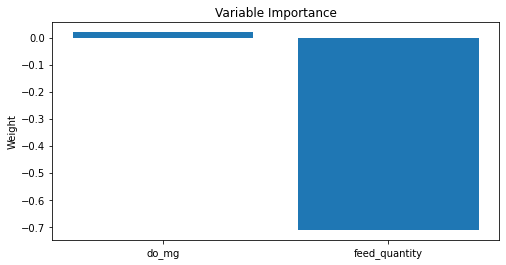

In [104]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [105]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 00:00:00,7.91,0.0
2021-07-21 00:10:00,7.85,0.0
2021-07-21 00:20:00,8.00,0.0
2021-07-21 00:30:00,8.10,0.0
2021-07-21 00:40:00,8.03,0.0
...,...,...
2021-09-10 23:10:00,9.19,0.0
2021-09-10 23:20:00,9.23,0.0
2021-09-10 23:30:00,9.16,0.0


In [120]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6894 nVar: 2


In [121]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6894 nVar: 1
nCar: 6894 nVar: 1


6894


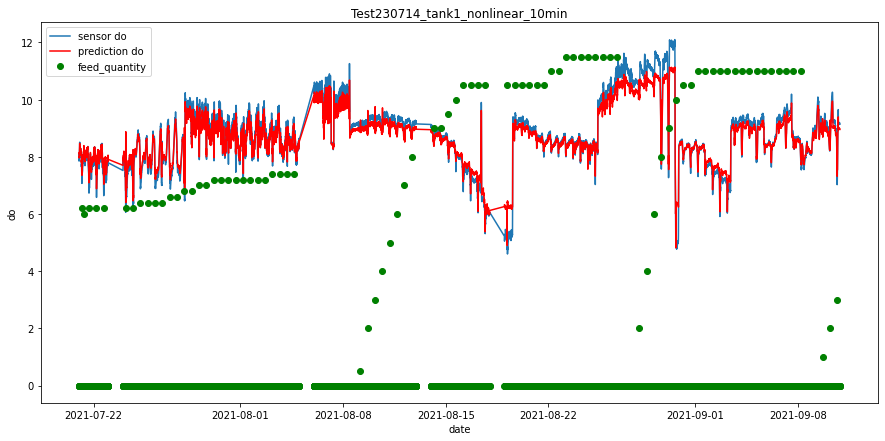

216/216 [==============================] - 1s 3ms/step - loss: 0.0798
MSE // MAE // R-squared  0.07979971170425415


In [122]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [109]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1422 nVar: 2


In [110]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1422 nVar: 1
nCar: 1422 nVar: 1


1422


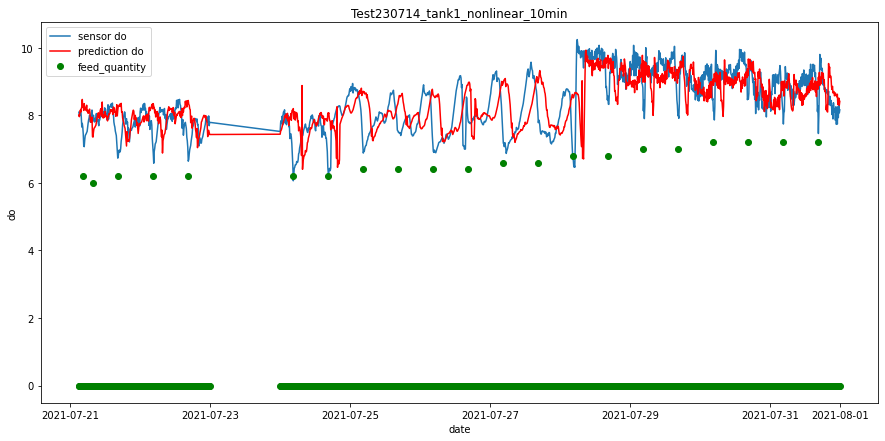

45/45 [==============================] - 0s 3ms/step - loss: 0.5310
MSE // MAE // R-squared  0.5310174226760864


In [111]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [112]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 126 nVar: 2


In [113]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 126 nVar: 1
nCar: 126 nVar: 1


126


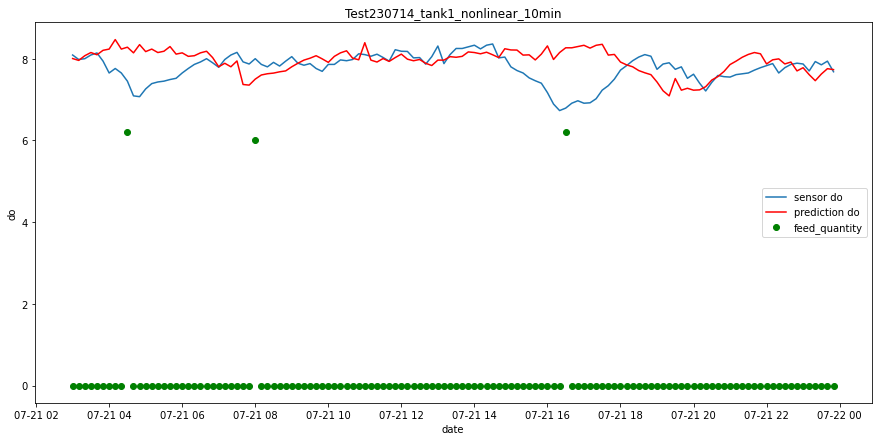

4/4 [==============================] - 0s 4ms/step - loss: 0.2744
MSE // MAE // R-squared  0.2743685841560364


In [114]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [115]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 2


In [116]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 1
nCar: 72 nVar: 1


72


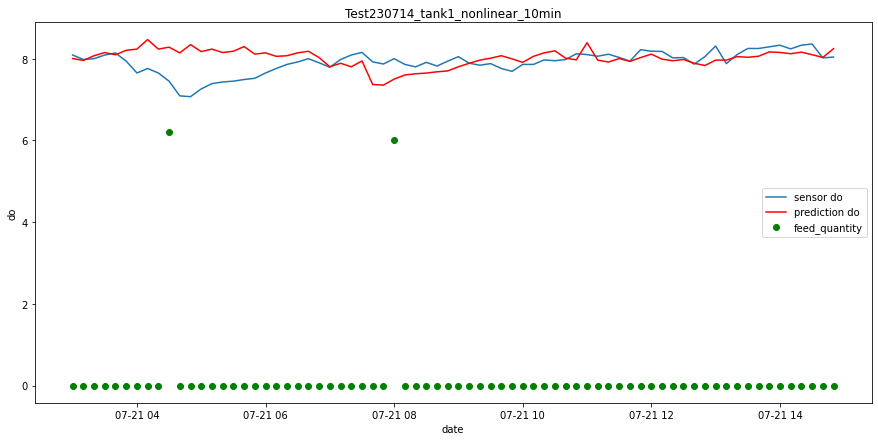

3/3 [==============================] - 0s 4ms/step - loss: 0.1541
MSE // MAE // R-squared  0.15410968661308289


In [117]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [118]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [119]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 1
nCar: 72 nVar: 1


72


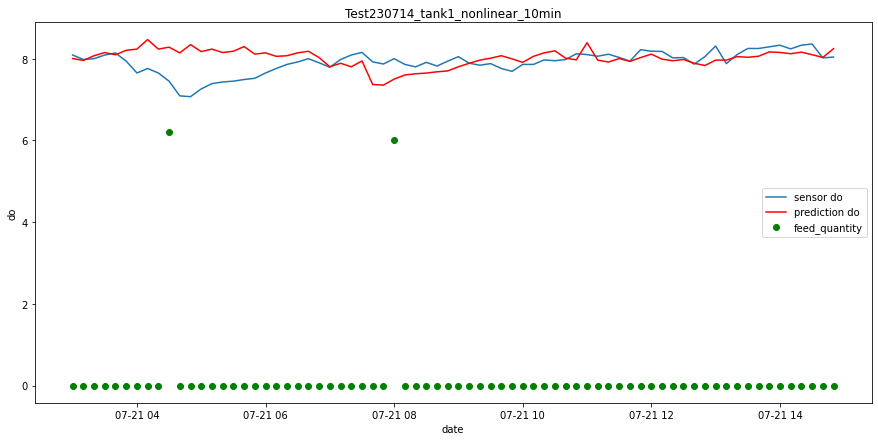

3/3 [==============================] - 0s 2ms/step - loss: 0.1541
MSE // MAE // R-squared  0.15410968661308289


In [101]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)